In [1]:
# Cell 1: Import necessary libraries
from sklearn.model_selection import StratifiedKFold
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random
import pandas as pd
import time
from tqdm.notebook import tqdm  # For showing progress indicators in Jupyter
import gc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0, MobileNetV2

2025-03-04 05:05:02.081174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741061102.094029 3312390 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741061102.098328 3312390 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-04 05:05:02.114386: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# ---------------------------
# GPU OPTIMIZATION
# ---------------------------

# Try to activate mixed precision (float16) for faster computation on GPU
# Catch errors in case of version issues
try:
    print("Trying to activate mixed precision training...")
    set_global_policy('mixed_float16')
    print("Mixed precision activated")
    use_mixed_precision = True
except Exception as e:
    print(f"Could not activate mixed precision: {e}")
    print("Continuing with standard precision format (float32)")
    use_mixed_precision = False

# Configure GPU memory management
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        try:
            # Allow memory growth
            tf.config.experimental.set_memory_growth(device, True)
            print(f"Memory growth activated for {device}")
        except Exception as e:
            print(f"Could not configure GPU memory growth: {e}")
    print(f"Found {len(physical_devices)} GPU devices")
else:
    print("No GPU devices found")

# Try to activate XLA compilation
try:
    # Activate XLA compilation for additional acceleration
    tf.config.optimizer.set_jit(True)
    print("XLA compilation activated for faster model execution")
except Exception as e:
    print(f"Could not activate XLA compilation: {e}")
    print("Continuing without XLA optimization")

Trying to activate mixed precision training...
Mixed precision activated
Memory growth activated for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found 1 GPU devices
XLA compilation activated for faster model execution


In [3]:
# ---------------------------
# CONSTANTS AND CONFIGURATIONS
# ---------------------------

# Define image size
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Here you must specify the correct paths to your data folders
# Example paths (update these with actual paths)
train_pneumonia_dir = "chest_xray/train/PNEUMONIA"
train_normal_dir = "chest_xray/train/NORMAL"

In [4]:
# ---------------------------
# DATA PREPARATION
# ---------------------------

# Function to collect all file paths and labels
def prepare_cv_data():
    print("Collecting file paths and labels...")
    pneumonia_files = [os.path.join(train_pneumonia_dir, f) for f in os.listdir(train_pneumonia_dir)]
    normal_files = [os.path.join(train_normal_dir, f) for f in os.listdir(train_normal_dir)]
    
    all_files = pneumonia_files + normal_files
    all_labels = [1] * len(pneumonia_files) + [0] * len(normal_files)
    
    # Zip together and shuffle
    combined = list(zip(all_files, all_labels))
    random.shuffle(combined)
    all_files, all_labels = zip(*combined)
    
    # Convert to numpy arrays
    all_files = np.array(all_files)
    all_labels = np.array(all_labels)
    
    print(f"Total number of images: {len(all_files)}")
    print(f"Pneumonia images: {np.sum(all_labels == 1)}")
    print(f"Normal images: {np.sum(all_labels == 0)}")
    
    return all_files, all_labels

# Optimized tf.data pipeline for data processing
def build_optimized_dataset(files, labels, is_training=False, batch_size=32, img_height=224, img_width=224):
    """
    Builds an optimized tf.data.Dataset pipeline for GPU training
    
    Args:
        files: List of image files
        labels: List of labels
        is_training: Whether the dataset is used for training (with augmentation)
        batch_size: Batch size
    
    Returns:
        tf.data.Dataset
    """
    # Function to load and process a single image
    def process_path(file_path, label):
        # Load the image
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [img_height, img_width])
        img = tf.cast(img, tf.float32) / 255.0
        
        # Image augmentation if training
        if is_training:
            # Basic augmentation without problematic rotation
            # Horizontal flip
            img = tf.image.random_flip_left_right(img)
            
            # Vertical flip (can be useful depending on the dataset)
            if tf.random.uniform(()) > 0.8:  # 20% chance
                img = tf.image.flip_up_down(img)
            
            # Central crop with varying size (simulates zoom)
            if tf.random.uniform(()) > 0.5:  # 50% chance
                # Random crop between 80% and 100% of the image
                crop_factor = tf.random.uniform([], 0.8, 1.0)
                crop_height = tf.cast(tf.cast(img_height, tf.float32) * crop_factor, tf.int32)
                crop_width = tf.cast(tf.cast(img_width, tf.float32) * crop_factor, tf.int32)
                
                # Ensure minimum size
                crop_height = tf.maximum(crop_height, img_height // 2)
                crop_width = tf.maximum(crop_width, img_width // 2)
                
                # Find center for crop
                h_offset = (img_height - crop_height) // 2
                w_offset = (img_width - crop_width) // 2
                
                # Crop and resize
                img = tf.image.crop_to_bounding_box(img, h_offset, w_offset, crop_height, crop_width)
                img = tf.image.resize(img, [img_height, img_width])
            
            # Adjust brightness
            img = tf.image.random_brightness(img, 0.2)
            
            # Adjust contrast
            img = tf.image.random_contrast(img, 0.8, 1.2)
            
            # Adjust saturation
            img = tf.image.random_saturation(img, 0.8, 1.2)
            
            # Adjust hue
            img = tf.image.random_hue(img, 0.1)
            
            # Clip values to [0,1]
            img = tf.clip_by_value(img, 0.0, 1.0)
        
        return img, label
    
    # Create tf.data.Dataset from files and labels
    file_paths_ds = tf.data.Dataset.from_tensor_slices(files)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    dataset = tf.data.Dataset.zip((file_paths_ds, labels_ds))
    
    # Shuffle with a large buffer if training
    if is_training:
        dataset = dataset.shuffle(buffer_size=min(len(files), 10000), 
                                  reshuffle_each_iteration=True)
    
    # Parallel data processing
    dataset = dataset.map(process_path, 
                         num_parallel_calls=tf.data.AUTOTUNE)
    
    # Batch and prefetch
    dataset = dataset.batch(batch_size, drop_remainder=is_training)
    
    # Cache the dataset in memory if it's not too large
    if len(files) < 5000:  # Adjust this limit based on available memory
        dataset = dataset.cache()
    
    # Prefetch to overlap data processing and model execution
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [5]:
# ---------------------------
# MODEL DEFINITIONS
# ---------------------------

# Standard CNN model (from original code)
def create_model():
    model = Sequential()
    
    # First convolutional block
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Second convolutional block
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Third convolutional block
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten layer
    model.add(Flatten())
    
    # Fully connected layers
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    # Output layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

# GPU-optimized CNN model
def create_gpu_optimized_model():
    """
    Creates a GPU-optimized CNN model that better utilizes parallel processing
    """
    model = tf.keras.Sequential()
    
    # First convolutional block - use of larger filter sizes to start
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(tf.keras.layers.BatchNormalization())  # Improves training and stability
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))
    
    # Second convolutional block
    model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.3))
    
    # Third convolutional block
    model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.4))
    
    # Global Average Pooling instead of Flatten - better performance and fewer parameters
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    
    # Fully connected layers
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    
    # Output layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    return model

In [6]:
# GPU-optimized Transfer Learning model
def create_optimized_transfer_learning_model(base_model_type='EfficientNetB0'):
    """
    Creates a GPU-optimized transfer learning model
    with pre-trained weights and efficient structure
    """
    # Default setting is EfficientNet which is efficient on GPU
    if base_model_type == 'EfficientNetB0':
        base_model = tf.keras.applications.EfficientNetB0(
            weights='imagenet', 
            include_top=False, 
            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
        )
    elif base_model_type == 'MobileNetV2':
        base_model = tf.keras.applications.MobileNetV2(
            weights='imagenet', 
            include_top=False, 
            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
        )
    elif base_model_type == 'VGG16':
        base_model = tf.keras.applications.VGG16(
            weights='imagenet', 
            include_top=False, 
            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
        )
    else:
        raise ValueError("Supported models: 'EfficientNetB0', 'MobileNetV2', 'VGG16'")
    
    # Freeze the pre-trained layers
    base_model.trainable = False
    
    # Use Functional API to build the model
    inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    # Preprocessing based on chosen model
    if base_model_type == 'EfficientNetB0':
        x = tf.keras.applications.efficientnet.preprocess_input(inputs)
    elif base_model_type == 'MobileNetV2':
        x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    elif base_model_type == 'VGG16':
        x = tf.keras.applications.vgg16.preprocess_input(inputs)
    
    # Get activations from base model
    x = base_model(x, training=False)
    
    # Add classification head
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    # Create complete model
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [7]:
# ---------------------------
# CROSS-VALIDATION
# ---------------------------

def perform_optimized_cross_validation(n_splits=5, epochs=20, batch_size=32, model_func=create_gpu_optimized_model):
    """
    Performs GPU-optimized k-fold cross-validation on the pneumonia dataset
    
    Args:
        n_splits: Number of folds for cross-validation
        epochs: Number of epochs for training
        batch_size: Batch size for training (increase to better utilize GPU)
        model_func: Function that creates the model
    
    Returns:
        Dictionary with results
    """
    # Initialize cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Prepare result storage
    fold_val_accuracies = []
    fold_val_losses = []
    fold_val_precisions = []
    fold_val_recalls = []
    fold_val_aucs = []
    results_df = pd.DataFrame(columns=[
        'fold', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall', 'val_auc',
        'train_samples', 'val_samples', 'pneumonia_train', 'normal_train',
        'pneumonia_val', 'normal_val', 'class_weight_normal', 'class_weight_pneumonia',
        'training_time'
    ])
    
    # To track the training process
    main_log_dir = os.path.join("logs", "pneumonia_cv_gpu_optimized")
    if not os.path.exists(main_log_dir):
        os.makedirs(main_log_dir)
    
    # Perform cross-validation
    print(f"Starting GPU-optimized {n_splits}-fold cross-validation...")
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(all_files, all_labels)):
        start_time = time.time()
        print(f"\n{'-'*50}")
        print(f"Training FOLD {fold+1}/{n_splits}")
        print(f"{'-'*50}")
        
        # Split data for this fold
        train_files, val_files = all_files[train_idx], all_files[val_idx]
        train_labels, val_labels = all_labels[train_idx], all_labels[val_idx]
        
        # Calculate class weights for this fold
        train_pneumonia_count = np.sum(train_labels == 1)
        train_normal_count = np.sum(train_labels == 0)
        
        weight_for_0 = (1 / train_normal_count) * (len(train_labels) / 2.0)
        weight_for_1 = (1 / train_pneumonia_count) * (len(train_labels) / 2.0)
        
        class_weights = {0: weight_for_0, 1: weight_for_1}
        
        # Use the optimized tf.data pipeline
        train_dataset = build_optimized_dataset(
            train_files, train_labels, is_training=True, batch_size=batch_size
        )
        
        val_dataset = build_optimized_dataset(
            val_files, val_labels, is_training=False, batch_size=batch_size
        )
        
        # Dataset info for logging
        train_pneumonia = np.sum(train_labels == 1)
        train_normal = np.sum(train_labels == 0)
        val_pneumonia = np.sum(val_labels == 1)
        val_normal = np.sum(val_labels == 0)
        
        print(f"Training dataset: {len(train_files)} images "
              f"({train_pneumonia} pneumonia, {train_normal} normal)")
        print(f"Validation dataset: {len(val_files)} images "
              f"({val_pneumonia} pneumonia, {val_normal} normal)")
        print(f"Class weights: Normal={class_weights[0]:.4f}, Pneumonia={class_weights[1]:.4f}")
        
        # Calculate steps_per_epoch for training
        steps_per_epoch = len(train_files) // batch_size
        validation_steps = len(val_files) // batch_size
        
        if steps_per_epoch == 0:
            steps_per_epoch = 1
        if validation_steps == 0:
            validation_steps = 1
            
        # Create and compile the model for this fold
        with tf.device('/gpu:0'):  # Explicit placement on GPU
            model = model_func()
            
            # Optimizer with custom learning rate
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
            
            # For mixed precision, use loss scaling
            if use_mixed_precision:
                try:
                    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
                    print("Loss scale optimizer activated for mixed precision")
                except Exception as e:
                    print(f"Could not configure loss scale optimizer: {e}")
                    print("Continuing with standard optimizer")
            
            model.compile(
                loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=[
                    'accuracy',
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    tf.keras.metrics.AUC()
                ]
            )
        
        # Define callbacks for this fold
        fold_log_dir = os.path.join(main_log_dir, f"fold_{fold+1}")
        if not os.path.exists(fold_log_dir):
            os.makedirs(fold_log_dir)
        
        callbacks = [
            tf.keras.callbacks.TensorBoard(
                log_dir=fold_log_dir,
                histogram_freq=1,
                write_graph=True,
                update_freq='epoch',
                profile_batch=0  # Disable profiling for performance
            ),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(fold_log_dir, 'best_model.h5'),
                monitor='val_accuracy',
                save_best_only=True,
                mode='max',
                verbose=1
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=8,
                restore_best_weights=True,
                verbose=1
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=4,
                min_lr=1e-6,
                verbose=1
            )
        ]
        
        # Train the model
        print(f"Training model for fold {fold+1}...")
        
        # Measure training time
        train_start = time.time()
        
        history = model.fit(
            train_dataset,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_dataset,
            validation_steps=validation_steps,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        train_time = time.time() - train_start
        print(f"Training time: {train_time:.2f} seconds")
        
        # Evaluate the model on the validation set
        print(f"Evaluating model for fold {fold+1}...")
        val_results = model.evaluate(
            val_dataset,
            steps=validation_steps,
            verbose=1
        )
        
        # Save results
        fold_val_loss = val_results[0]
        fold_val_acc = val_results[1]
        fold_val_precision = val_results[2]
        fold_val_recall = val_results[3]
        fold_val_auc = val_results[4]
        
        fold_val_losses.append(fold_val_loss)
        fold_val_accuracies.append(fold_val_acc)
        fold_val_precisions.append(fold_val_precision)
        fold_val_recalls.append(fold_val_recall)
        fold_val_aucs.append(fold_val_auc)
        
        # Save to dataframe
        results_df = results_df._append({
            'fold': fold+1,
            'val_accuracy': fold_val_acc,
            'val_loss': fold_val_loss,
            'val_precision': fold_val_precision,
            'val_recall': fold_val_recall,
            'val_auc': fold_val_auc,
            'train_samples': len(train_files),
            'val_samples': len(val_files),
            'pneumonia_train': train_pneumonia,
            'normal_train': train_normal,
            'pneumonia_val': val_pneumonia,
            'normal_val': val_normal,
            'class_weight_normal': class_weights[0],
            'class_weight_pneumonia': class_weights[1],
            'training_time': train_time
        }, ignore_index=True)
        
        # Plot learning history for this fold
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f'Fold {fold+1} Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='lower right')
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'Fold {fold+1} Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        
        plt.tight_layout()
        plt.savefig(os.path.join(fold_log_dir, 'training_history.png'))
        plt.show()
        
        fold_time = time.time() - start_time
        print(f"Fold {fold+1} completed in {fold_time:.2f} seconds")
        print(f"Validation - Accuracy: {fold_val_acc:.4f}, Loss: {fold_val_loss:.4f}")
        
        # Clear memory between folds
        tf.keras.backend.clear_session()
        
        # Explicitly free GPU memory
        gc.collect()
    
    # Calculate and display average results
    mean_val_loss = np.mean(fold_val_losses)
    mean_val_acc = np.mean(fold_val_accuracies)
    mean_val_precision = np.mean(fold_val_precisions)
    mean_val_recall = np.mean(fold_val_recalls)
    mean_val_auc = np.mean(fold_val_aucs)
    
    std_val_loss = np.std(fold_val_losses)
    std_val_acc = np.std(fold_val_accuracies)
    std_val_precision = np.std(fold_val_precisions)
    std_val_recall = np.std(fold_val_recalls)
    std_val_auc = np.std(fold_val_aucs)
    
    print("\n" + "="*50)
    print("Cross-validation results:")
    print("="*50)
    print(f"Average validation accuracy: {mean_val_acc:.4f} ± {std_val_acc:.4f}")
    print(f"Average validation loss: {mean_val_loss:.4f} ± {std_val_loss:.4f}")
    print(f"Average validation precision: {mean_val_precision:.4f} ± {std_val_precision:.4f}")
    print(f"Average validation recall: {mean_val_recall:.4f} ± {std_val_recall:.4f}")
    print(f"Average validation AUC: {mean_val_auc:.4f} ± {std_val_auc:.4f}")
    
    # Save results to file
    results_df.to_csv(os.path.join(main_log_dir, 'fold_results.csv'), index=False)
    
    # Plot results across folds
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.bar(range(1, n_splits+1), fold_val_accuracies)
    plt.axhline(y=mean_val_acc, color='r', linestyle='-', label=f'Mean: {mean_val_acc:.4f}')
    plt.title('Validation Accuracy by Fold')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.bar(range(1, n_splits+1), fold_val_losses)
    plt.axhline(y=mean_val_loss, color='r', linestyle='-', label=f'Mean: {mean_val_loss:.4f}')
    plt.title('Validation Loss by Fold')
    plt.xlabel('Fold')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.bar(range(1, n_splits+1), fold_val_precisions)
    plt.axhline(y=mean_val_precision, color='r', linestyle='-', label=f'Mean: {mean_val_precision:.4f}')
    plt.title('Validation Precision by Fold')
    plt.xlabel('Fold')
    plt.ylabel('Precision')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.bar(range(1, n_splits+1), fold_val_recalls)
    plt.axhline(y=mean_val_recall, color='r', linestyle='-', label=f'Mean: {mean_val_recall:.4f}')
    plt.title('Validation Recall by Fold')
    plt.xlabel('Fold')
    plt.ylabel('Recall')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(main_log_dir, 'cross_validation_results.png'))
    plt.show()
    
    # Collect results in a dictionary
    results_summary = {
        'mean_val_accuracy': mean_val_acc,
        'std_val_accuracy': std_val_acc,
        'mean_val_loss': mean_val_loss,
        'std_val_loss': std_val_loss,
        'mean_val_precision': mean_val_precision,
        'std_val_precision': std_val_precision,
        'mean_val_recall': mean_val_recall,
        'std_val_recall': std_val_recall,
        'mean_val_auc': mean_val_auc,
        'std_val_auc': std_val_auc,
        'num_folds': n_splits,
        'epochs': epochs,
        'batch_size': batch_size,
        'avg_training_time_per_fold': results_df['training_time'].mean()
    }
    
    return results_summary, results_df, model

In [8]:
# Import necessary libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import pandas as pd
from tensorflow.keras.models import load_model

def evaluate_model(model_path, test_files, test_labels, output_dir='evaluation_results', 
                   batch_size=32, img_height=224, img_width=224):
    """
    Thorough evaluation of a trained CNN model for pneumonia classification.
    
    Args:
        model_path: Path to the saved model (.h5 file)
        test_files: List of paths to test images
        test_labels: Labels for the test images (0 for normal, 1 for pneumonia)
        output_dir: Folder where evaluation results are saved
        batch_size: Batch size for prediction
        img_height: Image height
        img_width: Image width
        
    Returns:
        Dictionary with evaluation metrics
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Load the model
    print(f"Loading model from {model_path}...")
    model = load_model(model_path)
    
    # Summary of the model architecture
    model.summary()
    
    # Build evaluation dataset
    print("Building evaluation dataset...")
    test_dataset = build_optimized_dataset(
        test_files, test_labels, is_training=False, batch_size=batch_size
    )
    
    # Evaluate the model
    print("Evaluating model on test set...")
    test_results = model.evaluate(test_dataset, verbose=1)
    
    # Print evaluation results
    print("\n" + "="*50)
    print("Evaluation results:")
    print("="*50)
    metrics_names = ['Loss', 'Accuracy', 'Precision', 'Recall', 'AUC']
    for i, metric in enumerate(metrics_names):
        print(f"{metric}: {test_results[i]:.4f}")
    
    # Make predictions for all test images
    print("Generating predictions...")
    y_pred_probs = model.predict(test_dataset)
    y_pred_probs = y_pred_probs.flatten()  # Remove extra dimensions
    
    # Convert probabilities to classes
    y_pred = (y_pred_probs > 0.5).astype(int)
    
    # Compare with actual values (truncated to same length)
    min_len = min(len(y_pred), len(test_labels))
    y_true = test_labels[:min_len]
    y_pred = y_pred[:min_len]
    y_pred_probs = y_pred_probs[:min_len]
    
    # ==================
    # Confusion Matrix
    # ==================
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'), dpi=300)
    
    # Calculate metrics from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # ====================
    # Classification Report
    # ====================
    class_report = classification_report(y_true, y_pred, 
                                        target_names=['Normal', 'Pneumonia'],
                                        output_dict=True)
    
    # Save the report as CSV
    report_df = pd.DataFrame(class_report).transpose()
    report_df.to_csv(os.path.join(output_dir, 'classification_report.csv'))
    
    # ====================
    # ROC Curve
    # ====================
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'roc_curve.png'), dpi=300)
    
    # ====================
    # Precision-Recall Curve
    # ====================
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_probs)
    avg_precision = average_precision_score(y_true, y_pred_probs)
    
    plt.figure(figsize=(10, 8))
    plt.plot(recall_curve, precision_curve, lw=2, 
             label=f'Precision-Recall (AP = {avg_precision:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'precision_recall_curve.png'), dpi=300)
    
    # ====================
    # Prediction Probabilities
    # ====================
    plt.figure(figsize=(12, 6))
    
    # Separate probabilities for each class
    normal_probs = y_pred_probs[y_true == 0]
    pneumonia_probs = y_pred_probs[y_true == 1]
    
    plt.hist(normal_probs, bins=20, alpha=0.5, label='Normal (class 0)')
    plt.hist(pneumonia_probs, bins=20, alpha=0.5, label='Pneumonia (class 1)')
    plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold (0.5)')
    
    plt.xlabel('Prediction Probability for Pneumonia')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Prediction Probabilities')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'prediction_distribution.png'), dpi=300)
    
    # ====================
    # Threshold Evaluation
    # ====================
    # Calculate metrics for different threshold values
    thresholds = np.arange(0.1, 1.0, 0.1)
    threshold_results = []
    
    for threshold in thresholds:
        y_pred_thresh = (y_pred_probs >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_thresh).ravel()
        
        acc = (tp + tn) / (tp + tn + fp + fn)
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
        
        threshold_results.append({
            'Threshold': threshold,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'Specificity': spec,
            'F1-score': f1
        })
    
    # Create dataframe and save as CSV
    threshold_df = pd.DataFrame(threshold_results)
    threshold_df.to_csv(os.path.join(output_dir, 'threshold_evaluation.csv'), index=False)
    
    # Plot threshold effects
    plt.figure(figsize=(12, 8))
    
    plt.plot(threshold_df['Threshold'], threshold_df['Accuracy'], 'o-', label='Accuracy')
    plt.plot(threshold_df['Threshold'], threshold_df['Precision'], 'o-', label='Precision')
    plt.plot(threshold_df['Threshold'], threshold_df['Recall'], 'o-', label='Recall')
    plt.plot(threshold_df['Threshold'], threshold_df['Specificity'], 'o-', label='Specificity')
    plt.plot(threshold_df['Threshold'], threshold_df['F1-score'], 'o-', label='F1-score')
    
    plt.axvline(x=0.5, color='red', linestyle='--', label='Standard threshold (0.5)')
    plt.xlabel('Threshold Value')
    plt.ylabel('Metric Value')
    plt.title('Effect of Different Threshold Values on Model Metrics')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'threshold_metrics.png'), dpi=300)
    
    # ====================
    # Summary Report
    # ====================
    # Create a summary report with the most important metrics
    summary = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (Sensitivity)': recall,
        'Specificity': specificity,
        'F1-Score': f1_score,
        'AUC': roc_auc,
        'True Positives': tp,
        'True Negatives': tn,
        'False Positives': fp,
        'False Negatives': fn,
        'Average Precision Score': avg_precision
    }
    
    # Save summary as CSV
    summary_df = pd.DataFrame([summary])
    summary_df.to_csv(os.path.join(output_dir, 'summary_metrics.csv'), index=False)
    
    # Print summary results
    print("\n" + "="*50)
    print("Detailed evaluation results:")
    print("="*50)
    
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-Score: {f1_score:.4f}")
    print(f"AUC: {roc_auc:.4f}")
    
    # Return summary results
    return summary

Total number of images: 5216
Pneumonia images: 3875
Normal images: 1341
Starting GPU-optimized cross-validation...
Starting GPU-optimized 5-fold cross-validation...

--------------------------------------------------
Training FOLD 1/5
--------------------------------------------------


I0000 00:00:1741061281.770677 3312390 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79197 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


Training dataset: 4172 images (3100 pneumonia, 1072 normal)
Validation dataset: 1044 images (775 pneumonia, 269 normal)
Class weights: Normal=1.9459, Pneumonia=0.6729


/cluster/home/martnal/CNN/venv/lib64/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Loss scale optimizer activated for mixed precision
Training model for fold 1...
Epoch 1/20


I0000 00:00:1741061284.554810 3325216 service.cc:148] XLA service 0x151778005320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741061284.554856 3325216 service.cc:156]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
I0000 00:00:1741061284.566312 3325216 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1741061284.598841 3325216 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-03-04 05:08:06.176055: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-04 05:08:11.040300: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[64,112,112,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,112,112,128]{3,2,1,0}, f16[128,3,3,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7339 - auc: 0.7937 - loss: 0.6616 - precision: 0.8820 - recall: 0.7400

2025-03-04 05:08:57.428808: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_297', 20 bytes spill stores, 20 bytes spill loads

2025-03-04 05:08:57.611910: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_297', 12 bytes spill stores, 12 bytes spill loads

2025-03-04 05:08:57.648552: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_297', 4 bytes spill stores, 4 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.74121, saving model to logs/pneumonia_cv_gpu_optimized/fold_1/best_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - accuracy: 0.7346 - auc: 0.7948 - loss: 0.6591 - precision: 0.8826 - recall: 0.7406 - val_accuracy: 0.7412 - val_auc: 0.6715 - val_loss: 0.8563 - val_precision: 0.7412 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8638 - auc: 0.9300 - loss: 0.3416 - precision: 0.9599 - recall: 0.8512
Epoch 2: val_accuracy did not improve from 0.74121
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8638 - auc: 0.9301 - loss: 0.3415 - precision: 0.9599 - recall: 0.8513 - val_accuracy: 0.7412 - val_auc: 0.8834 - val_loss: 0.9933 - val_precision: 0.7412 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8712 - auc: 0.9470 - loss: 0.2938 - precision: 0.9646 - recall: 0.8575
Epoch 3: val_accuracy did not improve from 0.74121
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8713 - auc: 0.9470 - loss: 0.2939 - precision: 0.9645 - recall

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8949 - auc: 0.9631 - loss: 0.2457 - precision: 0.9707 - recall: 0.8846 - val_accuracy: 0.7744 - val_auc: 0.8991 - val_loss: 0.6962 - val_precision: 0.7688 - val_recall: 0.9947 - learning_rate: 5.0000e-04
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9114 - auc: 0.9710 - loss: 0.2200 - precision: 0.9708 - recall: 0.9076
Epoch 7: val_accuracy did not improve from 0.77441
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9114 - auc: 0.9710 - loss: 0.2197 - precision: 0.9709 - recall: 0.9076 - val_accuracy: 0.7500 - val_auc: 0.7462 - val_loss: 1.3473 - val_precision: 0.7478 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9082 - auc: 0.9696 - loss: 0.2266 - precision: 0.9691 - recall: 0.9048
Epoch 8: val_accuracy improved from 0.77441 to 0.87598, saving model to logs/pneumonia_cv_gpu_optimized/fold_1/best_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9083 - auc: 0.9697 - loss: 0.2263 - precision: 0.9692 - recall: 0.9049 - val_accuracy: 0.8760 - val_auc: 0.9516 - val_loss: 0.3312 - val_precision: 0.9593 - val_recall: 0.8696 - learning_rate: 5.0000e-04
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9113 - auc: 0.9726 - loss: 0.2138 - precision: 0.9701 - recall: 0.9081
Epoch 9: val_accuracy did not improve from 0.87598
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9114 - auc: 0.9726 - loss: 0.2135 - precision: 0.9702 - recall: 0.9081 - val_accuracy: 0.2939 - val_auc: 0.6932 - val_loss: 4.5227 - val_precision: 1.0000 - val_recall: 0.0474 - learning_rate: 5.0000e-04
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9178 - auc: 0.9739 - loss: 0.2070 - precision: 0.9725 - recall: 0.9149
Epoch 10: val_accuracy did not improve from 0.87598
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9179 - auc: 0.9739 - loss: 0.2068 - precision: 0.9725 

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9193 - auc: 0.9751 - loss: 0.2029 - precision: 0.9742 - recall: 0.9152 - val_accuracy: 0.9189 - val_auc: 0.9694 - val_loss: 0.1968 - val_precision: 0.9507 - val_recall: 0.9394 - learning_rate: 5.0000e-04
Epoch 12/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9181 - auc: 0.9748 - loss: 0.2089 - precision: 0.9701 - recall: 0.9178
Epoch 12: val_accuracy improved from 0.91895 to 0.92383, saving model to logs/pneumonia_cv_gpu_optimized/fold_1/best_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9182 - auc: 0.9748 - loss: 0.2085 - precision: 0.9702 - recall: 0.9178 - val_accuracy: 0.9238 - val_auc: 0.9771 - val_loss: 0.1859 - val_precision: 0.9749 - val_recall: 0.9209 - learning_rate: 5.0000e-04
Epoch 13/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9196 - auc: 0.9710 - loss: 0.2123 - precision: 0.9733 - recall: 0.9165
Epoch 13: val_accuracy did not improve from 0.92383
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9197 - auc: 0.9711 - loss: 0.2119 - precision: 0.9734 - recall: 0.9165 - val_accuracy: 0.4873 - val_auc: 0.9489 - val_loss: 1.7718 - val_precision: 1.0000 - val_recall: 0.3083 - learning_rate: 5.0000e-04
Epoch 14/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9276 - auc: 0.9765 - loss: 0.1952 - precision: 0.9754 - recall: 0.9254
Epoch 14: val_accuracy did not improve from 0.92383
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9277 - auc: 0.9766 - loss: 0.1948 - precision: 0.975

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9436 - auc: 0.9870 - loss: 0.1449 - precision: 0.9831 - recall: 0.9400 - val_accuracy: 0.9404 - val_auc: 0.9927 - val_loss: 0.1542 - val_precision: 0.9902 - val_recall: 0.9289 - learning_rate: 2.5000e-04
Epoch 19/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9410 - auc: 0.9838 - loss: 0.1627 - precision: 0.9816 - recall: 0.9378
Epoch 19: val_accuracy did not improve from 0.94043
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9411 - auc: 0.9839 - loss: 0.1623 - precision: 0.9817 - recall: 0.9378 - val_accuracy: 0.9385 - val_auc: 0.9858 - val_loss: 0.1555 - val_precision: 0.9328 - val_recall: 0.9881 - learning_rate: 2.5000e-04
Epoch 20/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9479 - auc: 0.9866 - loss: 0.1441 - precision: 0.9824 - recall: 0.9467
Epoch 20: val_accuracy did not improve from 0.94043
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9480 - auc: 0.9866 - loss: 0.1438 - precision: 0.982

/tmp/ipykernel_3312390/1611269026.py:195: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = results_df._append({


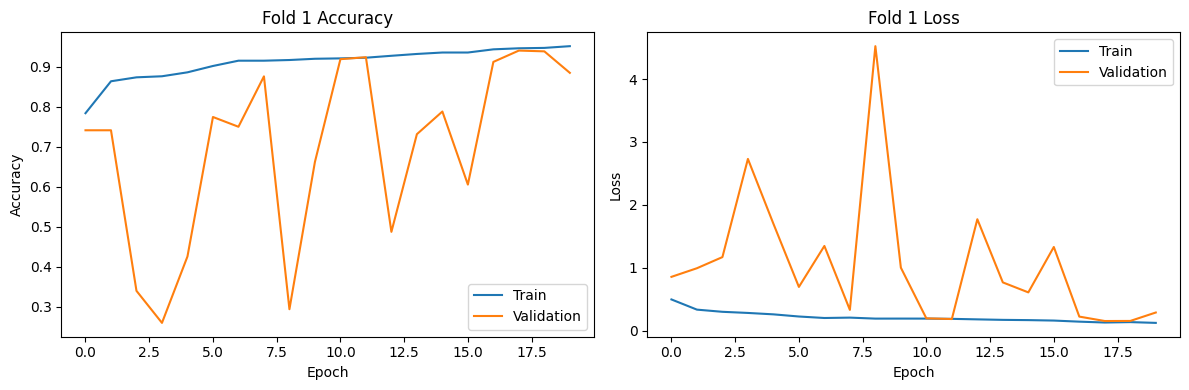

Fold 1 completed in 106.25 seconds
Validation - Accuracy: 0.9404, Loss: 0.1542

--------------------------------------------------
Training FOLD 2/5
--------------------------------------------------
Training dataset: 4173 images (3100 pneumonia, 1073 normal)
Validation dataset: 1043 images (775 pneumonia, 268 normal)
Class weights: Normal=1.9445, Pneumonia=0.6731


/cluster/home/martnal/CNN/venv/lib64/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Loss scale optimizer activated for mixed precision
Training model for fold 2...
Epoch 1/20


2025-03-04 05:09:52.408477: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1933', 4 bytes spill stores, 4 bytes spill loads

2025-03-04 05:09:52.555779: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1933', 12 bytes spill stores, 12 bytes spill loads

2025-03-04 05:09:54.489057: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3282', 500 bytes spill stores, 500 bytes spill loads

2025-03-04 05:09:54.584005: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3282', 436 bytes spill stores, 436 bytes spill loads



65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7644 - auc: 0.8123 - loss: 0.5714 - precision: 0.9086 - recall: 0.7592
Epoch 1: val_accuracy improved from -inf to 0.74316, saving model to logs/pneumonia_cv_gpu_optimized/fold_2/best_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - accuracy: 0.7649 - auc: 0.8132 - loss: 0.5698 - precision: 0.9089 - recall: 0.7596 - val_accuracy: 0.7432 - val_auc: 0.7936 - val_loss: 0.5239 - val_precision: 0.7432 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8441 - auc: 0.9166 - loss: 0.3671 - precision: 0.9500 - recall: 0.8340
Epoch 2: val_accuracy did not improve from 0.74316
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.8441 - auc: 0.9166 - loss: 0.3672 - precision: 0.9500 - recall: 0.8340 - val_accuracy: 0.7432 - val_auc: 0.5214 - val_loss: 1.4714 - val_precision: 0.7432 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8640 - auc: 0.9327 - loss: 0.3309 - precision: 0.9633 - recall: 0.8490
Epoch 3: val_accuracy improved from 0.74316 to 0.79688, saving model to logs/pneumonia_cv_gpu_optimized/fold_2/best_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.8640 - auc: 0.9327 - loss: 0.3308 - precision: 0.9633 - recall: 0.8491 - val_accuracy: 0.7969 - val_auc: 0.9491 - val_loss: 0.3502 - val_precision: 0.7920 - val_recall: 0.9855 - learning_rate: 0.0010
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8898 - auc: 0.9532 - loss: 0.2691 - precision: 0.9717 - recall: 0.8770
Epoch 4: val_accuracy did not improve from 0.79688
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.8898 - auc: 0.9532 - loss: 0.2691 - precision: 0.9716 - recall: 0.8771 - val_accuracy: 0.7432 - val_auc: 0.9075 - val_loss: 1.0030 - val_precision: 0.7432 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8923 - auc: 0.9596 - loss: 0.2514 - precision: 0.9693 - recall: 0.8828
Epoch 5: val_accuracy did not improve from 0.79688
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.8922 - auc: 0.9595 - loss: 0.2515 - precision: 0.9693 - recall: 

65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9099 - auc: 0.9699 - loss: 0.2133 - precision: 0.9779 - recall: 0.8988 - val_accuracy: 0.8037 - val_auc: 0.9156 - val_loss: 0.6757 - val_precision: 0.7966 - val_recall: 0.9882 - learning_rate: 5.0000e-04
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9212 - auc: 0.9740 - loss: 0.1947 - precision: 0.9848 - recall: 0.9078
Epoch 9: val_accuracy did not improve from 0.80371
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9211 - auc: 0.9740 - loss: 0.1947 - precision: 0.9848 - recall: 0.9077 - val_accuracy: 0.7432 - val_auc: 0.5038 - val_loss: 2.6718 - val_precision: 0.7432 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9275 - auc: 0.9779 - loss: 0.1825 - precision: 0.9827 - recall: 0.9185
Epoch 10: val_accuracy did not improve from 0.80371
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.9274 - auc: 0.9779 - loss: 0.1825 - precision: 0.9827 

65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9175 - auc: 0.9794 - loss: 0.1775 - precision: 0.9773 - recall: 0.9098 - val_accuracy: 0.8809 - val_auc: 0.9672 - val_loss: 0.3098 - val_precision: 0.8702 - val_recall: 0.9869 - learning_rate: 5.0000e-04
Epoch 12/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9199 - auc: 0.9754 - loss: 0.1916 - precision: 0.9812 - recall: 0.9094
Epoch 12: val_accuracy did not improve from 0.88086
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9200 - auc: 0.9754 - loss: 0.1914 - precision: 0.9812 - recall: 0.9095 - val_accuracy: 0.2568 - val_auc: 0.5007 - val_loss: 11.6924 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 13/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9219 - auc: 0.9793 - loss: 0.1781 - precision: 0.9790 - recall: 0.9142
Epoch 13: val_accuracy did not improve from 0.88086
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9219 - auc: 0.9793 - loss: 0.1779 - precisi

65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9307 - auc: 0.9842 - loss: 0.1557 - precision: 0.9819 - recall: 0.9236 - val_accuracy: 0.9033 - val_auc: 0.9858 - val_loss: 0.2333 - val_precision: 0.8913 - val_recall: 0.9908 - learning_rate: 2.5000e-04
Epoch 17/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9400 - auc: 0.9874 - loss: 0.1374 - precision: 0.9838 - recall: 0.9345
Epoch 17: val_accuracy did not improve from 0.90332
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9400 - auc: 0.9874 - loss: 0.1375 - precision: 0.9839 - recall: 0.9345 - val_accuracy: 0.7832 - val_auc: 0.8416 - val_loss: 1.0075 - val_precision: 0.7742 - val_recall: 1.0000 - learning_rate: 2.5000e-04
Epoch 18/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9404 - auc: 0.9874 - loss: 0.1366 - precision: 0.9849 - recall: 0.9340
Epoch 18: val_accuracy improved from 0.90332 to 0.91406, saving model to logs/pneumonia_cv_gpu_optimized/fold_2/best_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9404 - auc: 0.9874 - loss: 0.1367 - precision: 0.9849 - recall: 0.9340 - val_accuracy: 0.9141 - val_auc: 0.9871 - val_loss: 0.2285 - val_precision: 0.9941 - val_recall: 0.8896 - learning_rate: 2.5000e-04
Epoch 19/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9444 - auc: 0.9887 - loss: 0.1316 - precision: 0.9845 - recall: 0.9399
Epoch 19: val_accuracy improved from 0.91406 to 0.93652, saving model to logs/pneumonia_cv_gpu_optimized/fold_2/best_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9444 - auc: 0.9887 - loss: 0.1316 - precision: 0.9845 - recall: 0.9399 - val_accuracy: 0.9365 - val_auc: 0.9876 - val_loss: 0.1734 - val_precision: 0.9915 - val_recall: 0.9225 - learning_rate: 2.5000e-04
Epoch 20/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9466 - auc: 0.9891 - loss: 0.1260 - precision: 0.9885 - recall: 0.9390
Epoch 20: val_accuracy did not improve from 0.93652
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9465 - auc: 0.9891 - loss: 0.1260 - precision: 0.9884 - recall: 0.9389 - val_accuracy: 0.8203 - val_auc: 0.9227 - val_loss: 0.6360 - val_precision: 0.8053 - val_recall: 1.0000 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 19.
Training time: 124.73 seconds
Evaluating model for fold 2...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9282 - auc: 0.9849 - loss: 0.2051 - precision: 0.9928 - recall: 0.9089


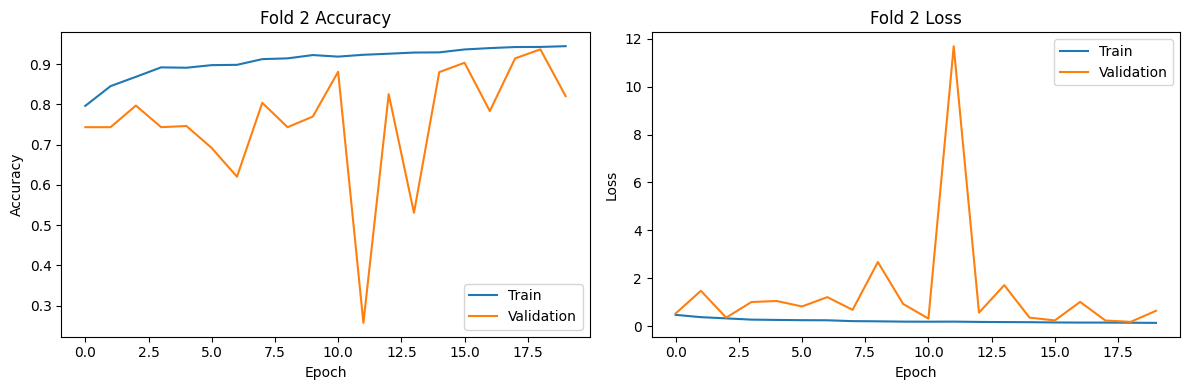

Fold 2 completed in 125.76 seconds
Validation - Accuracy: 0.9365, Loss: 0.1734

--------------------------------------------------
Training FOLD 3/5
--------------------------------------------------
Training dataset: 4173 images (3100 pneumonia, 1073 normal)
Validation dataset: 1043 images (775 pneumonia, 268 normal)
Class weights: Normal=1.9445, Pneumonia=0.6731


/cluster/home/martnal/CNN/venv/lib64/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Loss scale optimizer activated for mixed precision
Training model for fold 3...
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7076 - auc: 0.7813 - loss: 0.6055 - precision: 0.8822 - recall: 0.7008
Epoch 1: val_accuracy improved from -inf to 0.74707, saving model to logs/pneumonia_cv_gpu_optimized/fold_3/best_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.7086 - auc: 0.7825 - loss: 0.6038 - precision: 0.8828 - recall: 0.7018 - val_accuracy: 0.7471 - val_auc: 0.6563 - val_loss: 0.9060 - val_precision: 0.7471 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8484 - auc: 0.9186 - loss: 0.3669 - precision: 0.9582 - recall: 0.8339
Epoch 2: val_accuracy did not improve from 0.74707
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.8484 - auc: 0.9187 - loss: 0.3668 - precision: 0.9582 - recall: 0.8340 - val_accuracy: 0.7471 - val_auc: 0.5000 - val_loss: 2.5609 - val_precision: 0.7471 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8614 - auc: 0.9337 - loss: 0.3225 - precision: 0.9603 - recall: 0.8500
Epoch 3: val_accuracy did not improve from 0.74707
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.8614 - auc: 0.9338 - loss: 0.3224 - precision: 0.9603 - recall:

65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.8691 - auc: 0.9425 - loss: 0.3021 - precision: 0.9632 - recall: 0.8580 - val_accuracy: 0.7695 - val_auc: 0.9056 - val_loss: 0.5204 - val_precision: 0.7653 - val_recall: 0.9974 - learning_rate: 0.0010
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8743 - auc: 0.9512 - loss: 0.2763 - precision: 0.9679 - recall: 0.8608
Epoch 5: val_accuracy did not improve from 0.76953
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.8745 - auc: 0.9512 - loss: 0.2763 - precision: 0.9678 - recall: 0.8610 - val_accuracy: 0.7471 - val_auc: 0.6703 - val_loss: 1.3985 - val_precision: 0.7471 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8870 - auc: 0.9600 - loss: 0.2491 - precision: 0.9748 - recall: 0.8717
Epoch 6: val_accuracy did not improve from 0.76953
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.8872 - auc: 0.9600 - loss: 0.2491 - precision: 0.9748 - recall: 

65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9169 - auc: 0.9789 - loss: 0.1817 - precision: 0.9814 - recall: 0.9063 - val_accuracy: 0.9336 - val_auc: 0.9764 - val_loss: 0.1756 - val_precision: 0.9703 - val_recall: 0.9399 - learning_rate: 5.0000e-04
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9190 - auc: 0.9786 - loss: 0.1831 - precision: 0.9803 - recall: 0.9102
Epoch 11: val_accuracy did not improve from 0.93359
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9190 - auc: 0.9786 - loss: 0.1832 - precision: 0.9802 - recall: 0.9103 - val_accuracy: 0.2549 - val_auc: 0.5327 - val_loss: 7.8969 - val_precision: 1.0000 - val_recall: 0.0026 - learning_rate: 5.0000e-04
Epoch 12/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9202 - auc: 0.9772 - loss: 0.1888 - precision: 0.9820 - recall: 0.9101
Epoch 12: val_accuracy did not improve from 0.93359
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9202 - auc: 0.9772 - loss: 0.1888 - precision: 0.982

65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9427 - auc: 0.9872 - loss: 0.1402 - precision: 0.9877 - recall: 0.9351 - val_accuracy: 0.9404 - val_auc: 0.9779 - val_loss: 0.1938 - val_precision: 0.9835 - val_recall: 0.9359 - learning_rate: 2.5000e-04
Epoch 18/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9447 - auc: 0.9881 - loss: 0.1326 - precision: 0.9882 - recall: 0.9374
Epoch 18: val_accuracy improved from 0.94043 to 0.94629, saving model to logs/pneumonia_cv_gpu_optimized/fold_3/best_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9447 - auc: 0.9881 - loss: 0.1328 - precision: 0.9882 - recall: 0.9374 - val_accuracy: 0.9463 - val_auc: 0.9753 - val_loss: 0.1674 - val_precision: 0.9647 - val_recall: 0.9634 - learning_rate: 2.5000e-04
Epoch 19/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9416 - auc: 0.9877 - loss: 0.1370 - precision: 0.9859 - recall: 0.9353
Epoch 19: val_accuracy did not improve from 0.94629
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9416 - auc: 0.9877 - loss: 0.1370 - precision: 0.9859 - recall: 0.9354 - val_accuracy: 0.9238 - val_auc: 0.9783 - val_loss: 0.2177 - val_precision: 0.9174 - val_recall: 0.9869 - learning_rate: 2.5000e-04
Epoch 20/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9445 - auc: 0.9894 - loss: 0.1260 - precision: 0.9863 - recall: 0.9390
Epoch 20: val_accuracy improved from 0.94629 to 0.95605, saving model to logs/pneumonia_cv_gpu_optimized/fold_3/best_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9445 - auc: 0.9894 - loss: 0.1262 - precision: 0.9862 - recall: 0.9390 - val_accuracy: 0.9561 - val_auc: 0.9843 - val_loss: 0.1255 - val_precision: 0.9580 - val_recall: 0.9843 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 20.
Training time: 110.11 seconds
Evaluating model for fold 3...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9475 - auc: 0.9799 - loss: 0.1475 - precision: 0.9495 - recall: 0.9802


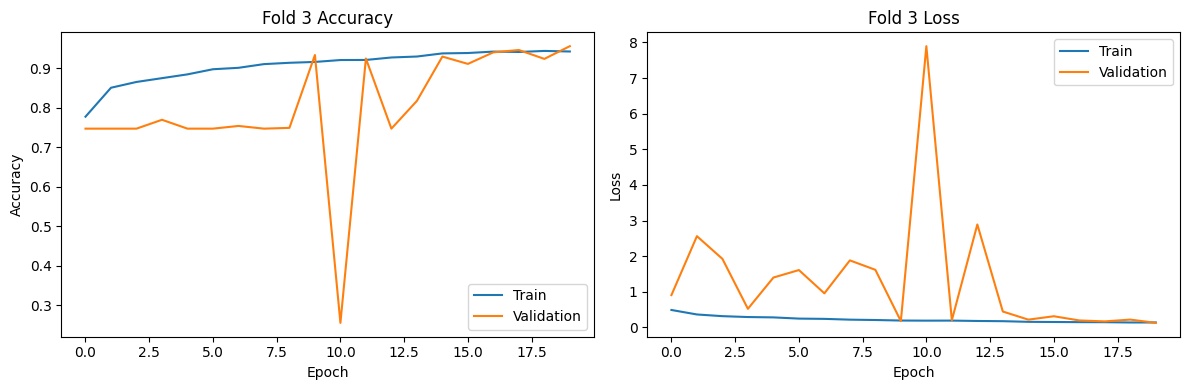

Fold 3 completed in 111.13 seconds
Validation - Accuracy: 0.9561, Loss: 0.1255

--------------------------------------------------
Training FOLD 4/5
--------------------------------------------------
Training dataset: 4173 images (3100 pneumonia, 1073 normal)
Validation dataset: 1043 images (775 pneumonia, 268 normal)
Class weights: Normal=1.9445, Pneumonia=0.6731


/cluster/home/martnal/CNN/venv/lib64/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Loss scale optimizer activated for mixed precision
Training model for fold 4...
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6996 - auc: 0.7904 - loss: 0.6007 - precision: 0.9038 - recall: 0.6579
Epoch 1: val_accuracy improved from -inf to 0.74316, saving model to logs/pneumonia_cv_gpu_optimized/fold_4/best_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - accuracy: 0.7008 - auc: 0.7916 - loss: 0.5987 - precision: 0.9043 - recall: 0.6594 - val_accuracy: 0.7432 - val_auc: 0.6902 - val_loss: 0.8076 - val_precision: 0.7432 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8309 - auc: 0.9093 - loss: 0.3986 - precision: 0.9348 - recall: 0.8285
Epoch 2: val_accuracy did not improve from 0.74316
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.8311 - auc: 0.9095 - loss: 0.3981 - precision: 0.9350 - recall: 0.8286 - val_accuracy: 0.7432 - val_auc: 0.7337 - val_loss: 0.9811 - val_precision: 0.7432 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8551 - auc: 0.9160 - loss: 0.3858 - precision: 0.9458 - recall: 0.8526
Epoch 3: val_accuracy did not improve from 0.74316
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.8552 - auc: 0.9161 - loss: 0.3853 - precision: 0.9459 - recall

65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.8968 - auc: 0.9551 - loss: 0.2697 - precision: 0.9638 - recall: 0.8938 - val_accuracy: 0.7637 - val_auc: 0.8370 - val_loss: 0.5882 - val_precision: 0.7717 - val_recall: 0.9685 - learning_rate: 0.0010
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8929 - auc: 0.9498 - loss: 0.2891 - precision: 0.9645 - recall: 0.8875
Epoch 7: val_accuracy did not improve from 0.76367
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.8930 - auc: 0.9499 - loss: 0.2887 - precision: 0.9645 - recall: 0.8876 - val_accuracy: 0.7607 - val_auc: 0.9276 - val_loss: 0.6424 - val_precision: 0.7565 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9045 - auc: 0.9565 - loss: 0.2661 - precision: 0.9676 - recall: 0.9008
Epoch 8: val_accuracy improved from 0.76367 to 0.83398, saving model to logs/pneumonia_cv_gpu_optimized/fold_4/best_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9045 - auc: 0.9565 - loss: 0.2660 - precision: 0.9676 - recall: 0.9007 - val_accuracy: 0.8340 - val_auc: 0.9009 - val_loss: 0.3600 - val_precision: 0.8764 - val_recall: 0.9041 - learning_rate: 0.0010
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9041 - auc: 0.9624 - loss: 0.2442 - precision: 0.9724 - recall: 0.8954
Epoch 9: val_accuracy did not improve from 0.83398
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9041 - auc: 0.9624 - loss: 0.2441 - precision: 0.9724 - recall: 0.8954 - val_accuracy: 0.7871 - val_auc: 0.9318 - val_loss: 0.6837 - val_precision: 0.7779 - val_recall: 0.9987 - learning_rate: 0.0010
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9045 - auc: 0.9609 - loss: 0.2506 - precision: 0.9698 - recall: 0.8985
Epoch 10: val_accuracy improved from 0.83398 to 0.92676, saving model to logs/pneumonia_cv_gpu_optimized/fold_4/best_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9045 - auc: 0.9609 - loss: 0.2503 - precision: 0.9699 - recall: 0.8986 - val_accuracy: 0.9268 - val_auc: 0.9688 - val_loss: 0.2020 - val_precision: 0.9432 - val_recall: 0.9593 - learning_rate: 0.0010
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9027 - auc: 0.9618 - loss: 0.2504 - precision: 0.9671 - recall: 0.8988
Epoch 11: val_accuracy did not improve from 0.92676
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9028 - auc: 0.9619 - loss: 0.2500 - precision: 0.9672 - recall: 0.8988 - val_accuracy: 0.3643 - val_auc: 0.9585 - val_loss: 2.0011 - val_precision: 1.0000 - val_recall: 0.1445 - learning_rate: 0.0010
Epoch 12/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9124 - auc: 0.9650 - loss: 0.2369 - precision: 0.9712 - recall: 0.9083
Epoch 12: val_accuracy did not improve from 0.92676
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9124 - auc: 0.9651 - loss: 0.2367 - precision: 0.9712 - reca

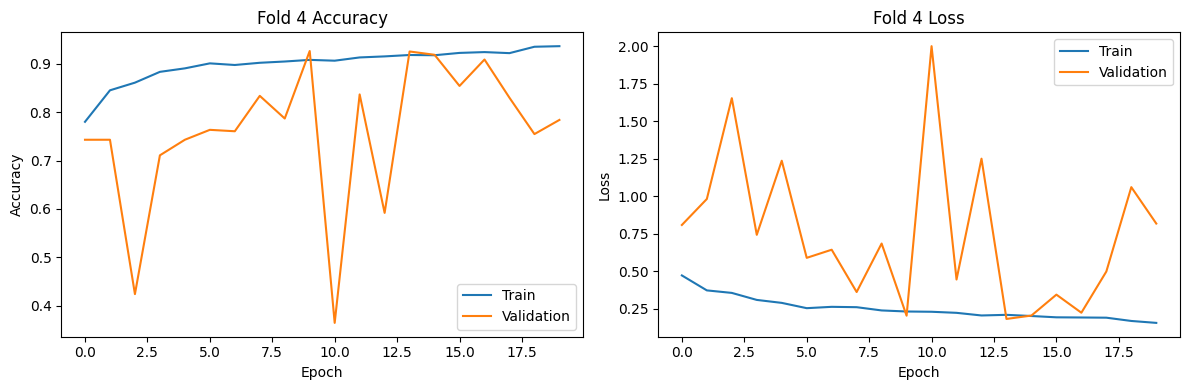

Fold 4 completed in 111.06 seconds
Validation - Accuracy: 0.9258, Loss: 0.1803

--------------------------------------------------
Training FOLD 5/5
--------------------------------------------------
Training dataset: 4173 images (3100 pneumonia, 1073 normal)
Validation dataset: 1043 images (775 pneumonia, 268 normal)
Class weights: Normal=1.9445, Pneumonia=0.6731


/cluster/home/martnal/CNN/venv/lib64/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Loss scale optimizer activated for mixed precision
Training model for fold 5...
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6815 - auc: 0.8056 - loss: 0.6267 - precision: 0.9210 - recall: 0.6222
Epoch 1: val_accuracy improved from -inf to 0.74609, saving model to logs/pneumonia_cv_gpu_optimized/fold_5/best_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step - accuracy: 0.6831 - auc: 0.8067 - loss: 0.6244 - precision: 0.9213 - recall: 0.6243 - val_accuracy: 0.7461 - val_auc: 0.5965 - val_loss: 0.8058 - val_precision: 0.7461 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8711 - auc: 0.9403 - loss: 0.3084 - precision: 0.9655 - recall: 0.8585
Epoch 2: val_accuracy improved from 0.74609 to 0.74902, saving model to logs/pneumonia_cv_gpu_optimized/fold_5/best_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.8710 - auc: 0.9403 - loss: 0.3086 - precision: 0.9654 - recall: 0.8584 - val_accuracy: 0.7490 - val_auc: 0.7889 - val_loss: 0.5242 - val_precision: 0.8468 - val_recall: 0.8102 - learning_rate: 0.0010
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8831 - auc: 0.9476 - loss: 0.2873 - precision: 0.9666 - recall: 0.8741
Epoch 3: val_accuracy did not improve from 0.74902
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.8830 - auc: 0.9476 - loss: 0.2875 - precision: 0.9666 - recall: 0.8740 - val_accuracy: 0.2539 - val_auc: 0.8663 - val_loss: 2.3851 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9065 - auc: 0.9583 - loss: 0.2478 - precision: 0.9728 - recall: 0.9002
Epoch 4: val_accuracy improved from 0.74902 to 0.77441, saving model to logs/pneumonia_cv_gpu_optimized/fold_5/best_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9063 - auc: 0.9582 - loss: 0.2481 - precision: 0.9727 - recall: 0.8999 - val_accuracy: 0.7744 - val_auc: 0.8352 - val_loss: 0.7551 - val_precision: 0.9420 - val_recall: 0.7435 - learning_rate: 0.0010
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9119 - auc: 0.9633 - loss: 0.2314 - precision: 0.9795 - recall: 0.9012
Epoch 5: val_accuracy did not improve from 0.77441
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.9118 - auc: 0.9633 - loss: 0.2315 - precision: 0.9794 - recall: 0.9011 - val_accuracy: 0.2891 - val_auc: 0.8775 - val_loss: 2.3082 - val_precision: 1.0000 - val_recall: 0.0471 - learning_rate: 0.0010
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8969 - auc: 0.9598 - loss: 0.2466 - precision: 0.9735 - recall: 0.8864
Epoch 6: val_accuracy did not improve from 0.77441

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step -

65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9112 - auc: 0.9695 - loss: 0.2139 - precision: 0.9790 - recall: 0.9007 - val_accuracy: 0.8291 - val_auc: 0.9367 - val_loss: 0.4753 - val_precision: 0.9742 - val_recall: 0.7919 - learning_rate: 5.0000e-04
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9180 - auc: 0.9716 - loss: 0.2010 - precision: 0.9796 - recall: 0.9093
Epoch 8: val_accuracy did not improve from 0.82910
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9179 - auc: 0.9716 - loss: 0.2011 - precision: 0.9796 - recall: 0.9092 - val_accuracy: 0.6201 - val_auc: 0.8556 - val_loss: 1.7718 - val_precision: 0.9921 - val_recall: 0.4948 - learning_rate: 5.0000e-04
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9252 - auc: 0.9723 - loss: 0.1961 - precision: 0.9809 - recall: 0.9180
Epoch 9: val_accuracy improved from 0.82910 to 0.83984, saving model to logs/pneumonia_cv_gpu_optimized/fold_5/best_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9251 - auc: 0.9723 - loss: 0.1962 - precision: 0.9808 - recall: 0.9179 - val_accuracy: 0.8398 - val_auc: 0.9738 - val_loss: 0.4396 - val_precision: 0.9918 - val_recall: 0.7919 - learning_rate: 5.0000e-04
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9155 - auc: 0.9728 - loss: 0.1972 - precision: 0.9780 - recall: 0.9076
Epoch 10: val_accuracy did not improve from 0.83984
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9154 - auc: 0.9728 - loss: 0.1974 - precision: 0.9779 - recall: 0.9075 - val_accuracy: 0.7627 - val_auc: 0.8022 - val_loss: 1.1105 - val_precision: 0.7587 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9251 - auc: 0.9756 - loss: 0.1860 - precision: 0.9820 - recall: 0.9168
Epoch 11: val_accuracy did not improve from 0.83984
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9250 - auc: 0.9756 - loss: 0.1861 - precision: 0.981

65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9257 - auc: 0.9767 - loss: 0.1810 - precision: 0.9813 - recall: 0.9181 - val_accuracy: 0.9385 - val_auc: 0.9753 - val_loss: 0.1772 - val_precision: 0.9692 - val_recall: 0.9476 - learning_rate: 5.0000e-04
Epoch 13/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9227 - auc: 0.9771 - loss: 0.1790 - precision: 0.9822 - recall: 0.9134
Epoch 13: val_accuracy did not improve from 0.93848
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9227 - auc: 0.9771 - loss: 0.1791 - precision: 0.9821 - recall: 0.9134 - val_accuracy: 0.8906 - val_auc: 0.9714 - val_loss: 0.3097 - val_precision: 0.8808 - val_recall: 0.9869 - learning_rate: 5.0000e-04
Epoch 14/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9254 - auc: 0.9789 - loss: 0.1704 - precision: 0.9827 - recall: 0.9165
Epoch 14: val_accuracy did not improve from 0.93848
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9254 - auc: 0.9789 - loss: 0.1705 - precision: 0.982

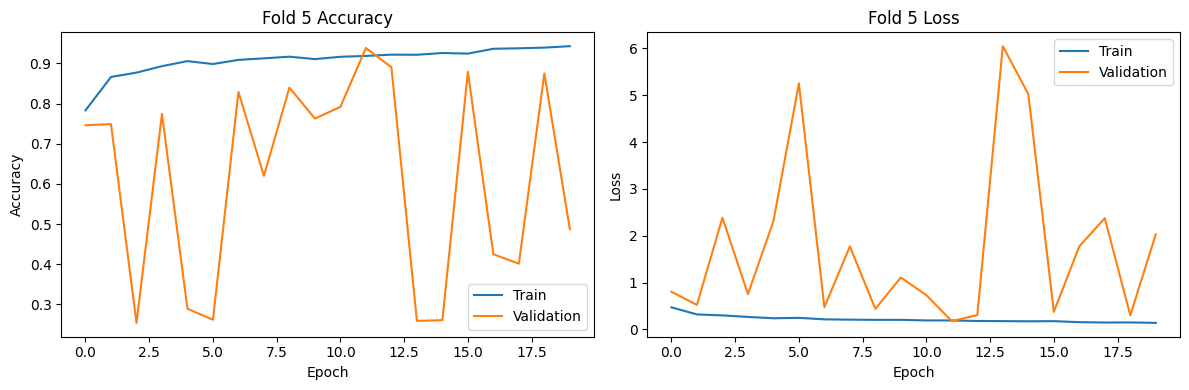

Fold 5 completed in 111.32 seconds
Validation - Accuracy: 0.9385, Loss: 0.1772

Cross-validation results:
Average validation accuracy: 0.9395 ± 0.0097
Average validation loss: 0.1621 ± 0.0205
Average validation precision: 0.9792 ± 0.0133
Average validation recall: 0.9390 ± 0.0254
Average validation AUC: 0.9858 ± 0.0059


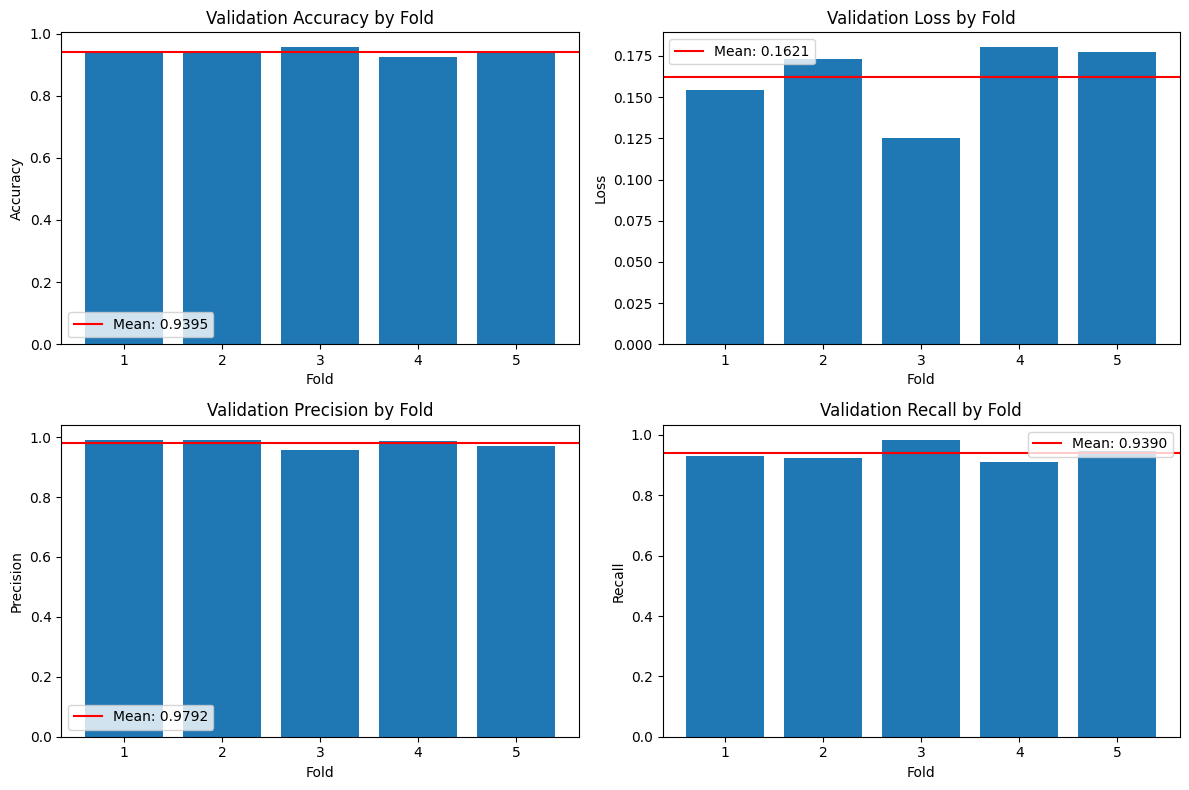

Total runtime: 568.45 seconds

Results with GPU-optimized model:
mean_val_accuracy: 0.9395
std_val_accuracy: 0.0097
mean_val_loss: 0.1621
std_val_loss: 0.0205
mean_val_precision: 0.9792
std_val_precision: 0.0133
mean_val_recall: 0.9390
std_val_recall: 0.0254
mean_val_auc: 0.9858
std_val_auc: 0.0059
num_folds: 5
epochs: 20
batch_size: 64
avg_training_time_per_fold: 111.9242


In [9]:
# ---------------------------
# MAIN PROGRAM
# ---------------------------

if __name__ == "__main__":
    # 1. Load the dataset
    all_files, all_labels = prepare_cv_data()
    
    # 2. Define hyperparameters for training
    batch_size = 64  # Increase this to 128 if the GPU has enough memory
    epochs = 20
    n_splits = 5
    
    # 3. Run the optimized cross-validation
    print("Starting GPU-optimized cross-validation...")
    start_time = time.time()
    
    # Choose model: create_model, create_gpu_optimized_model, or create_optimized_transfer_learning_model
    cv_results, cv_df, final_model = perform_optimized_cross_validation(
        n_splits=n_splits,
        epochs=epochs,
        batch_size=batch_size,
        model_func=create_gpu_optimized_model  # Choose your optimized model
    )
    
    total_time = time.time() - start_time
    print(f"Total runtime: {total_time:.2f} seconds")
    
    # 4. Display results
    print("\nResults with GPU-optimized model:")
    for key, value in cv_results.items():
        if isinstance(value, float):
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: {value}")
    
    # 5. Save the model
    final_model.save('pneumonia_model_gpu_optimized.h5')